In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm 

**Data for LoL matches from 2019 - 2022**

In [2]:
data_2022 = pd.read_csv("/Users/ryanlucas/Downloads/2022_LoL_esports_match_data_from_OraclesElixir_20221014.csv")
data_2021 = pd.read_csv("/Users/ryanlucas/Downloads/2021_LoL_esports_match_data_from_OraclesElixir_20221014.csv")
data_2020 = pd.read_csv("/Users/ryanlucas/Downloads/2020_LoL_esports_match_data_from_OraclesElixir_20221015.csv")
data_2019 = pd.read_csv("/Users/ryanlucas/Downloads/2019_LoL_esports_match_data_from_OraclesElixir_20221015.csv")

/var/folders/bs/b4wxnr6x4rs1cd3wk97bhy6r0000gn/T/ipykernel_41771/705383748.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022 = pd.read_csv("/Users/ryanlucas/Downloads/2022_LoL_esports_match_data_from_OraclesElixir_20221014.csv")


In [3]:
together = pd.concat([data_2019, data_2020, data_2021, data_2022], axis = 0)

In [4]:
together.reset_index(inplace = True)

**We consider only leagues LCS, LCK, LPL and LEC**

In [5]:
league_filtered = together[together['league'].isin(["LCS", "LCK", "LPL", "LEC"])]

**We also only want to consider teams. The simple way to do this in Python is to look for rows where playerid is NaN**

In [6]:
team_filtered = league_filtered[league_filtered['playerid'].isna()]

**I manually filtered through the columns to decide which columns could potentially be relevant. I consulted Paul on all 'controversial' columns**

In [7]:
relevant_columns = ['gameid', 'position', 'playerid', 'teamid', 
                    'champion', 'ban1', 'ban2', 'ban3', 'ban4', 
                    'ban5', 'kills', 'deaths', 'assists', 'teamkills', 
                    'teamdeaths',  'doublekills', 
                    'triplekills', 'quadrakills', 'pentakills', 'firstblood',
                    'firstbloodkill', 'firstbloodassist', 'team kpm', 'ckpm',
                    'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes',
                    'opp_elementaldrakes', 'elders', 'opp_elders', 'firstherald', 'heralds',
                    'opp_heralds', 'firstbaron', 'barons', 'opp_barons', 'firsttower',
                    'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers',
                    'turretplates', 'opp_turretplates', 'inhibitors', 'opp_inhibitors',
                    'damagetochampions', 'dpm', 'damageshare', 'damagetakenperminute',
                    'damagemitigatedperminute', 'wardsplaced', 'wpm', 'wardskilled',
                    'wcpm', 'controlwardsbought','vspm', 'totalgold',
                    'earnedgold', 'earned gpm', 'earnedgoldshare', 'goldspent', 'gspd',
                     'minionkills', 'monsterkills', 'cspm', 'goldat10', 'xpat10',
                    'csat10', 'opp_goldat10', 'opp_xpat10', 'opp_csat10', 'golddiffat10', 'xpdiffat10',
                    'csdiffat10', 'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10',
                    'opp_deathsat10', 'goldat15', 'xpat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15',
                    'golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsat15', 'assistsat15', 'opp_killsat15'
                    ]


relevant_columns = sorted(relevant_columns)
print(sorted(relevant_columns))

filtered_y = team_filtered.loc[:, 'result']
filtered = team_filtered.loc[:, relevant_columns]


['assists', 'assistsat10', 'assistsat15', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'barons', 'champion', 'ckpm', 'controlwardsbought', 'csat10', 'csat15', 'csdiffat10', 'csdiffat15', 'cspm', 'damagemitigatedperminute', 'damageshare', 'damagetakenperminute', 'damagetochampions', 'deaths', 'deathsat10', 'doublekills', 'dpm', 'dragons', 'earned gpm', 'earnedgold', 'earnedgoldshare', 'elders', 'elementaldrakes', 'firstbaron', 'firstblood', 'firstbloodassist', 'firstbloodkill', 'firstdragon', 'firstherald', 'firstmidtower', 'firsttothreetowers', 'firsttower', 'gameid', 'goldat10', 'goldat15', 'golddiffat10', 'golddiffat15', 'goldspent', 'gspd', 'heralds', 'inhibitors', 'kills', 'killsat10', 'killsat15', 'minionkills', 'monsterkills', 'opp_assistsat10', 'opp_barons', 'opp_csat10', 'opp_csat15', 'opp_deathsat10', 'opp_dragons', 'opp_elders', 'opp_elementaldrakes', 'opp_goldat10', 'opp_goldat15', 'opp_heralds', 'opp_inhibitors', 'opp_killsat10', 'opp_killsat15', 'opp_towers', 'opp_turretplates'

**I also filtered out player-specific categorical features and other non-numeric categorical features. NOTE: we should consider using a more granular objective that considers the position and attributes of each player**

In [8]:
categorical_features = ['ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'champion', 'teamid', 'playerid', 'position', 'gameid']

In [9]:
filtered = filtered.loc[:, ~filtered.columns.isin(categorical_features)]

**Generating Correlation for non-nan values**

In [10]:
correlations = {}
significance = {}
for column in filtered.columns[1:]:
    x = filtered[column]
    idx_non_nan = []
    for i in x.index:
        if not np.isnan(x.loc[i]):
            idx_non_nan.append(i)
    
    my_rho, sig = pearsonr(filtered_y.loc[idx_non_nan], x.loc[idx_non_nan].values)
    correlations[column] = my_rho
    significance[column] = float(sig)

In [11]:
correlations = pd.DataFrame(correlations, index = ["Correlation"]).T
significance = pd.DataFrame(significance, index = ["Significance"]).T

In [12]:
correlations = pd.concat([correlations, significance], axis = 1)

In [13]:
correlations_top = correlations.tail(10)
correlatins_bottom = correlations.head(10)

In [14]:
correlations_top.index

Index(['turretplates', 'vspm', 'wardskilled', 'wardsplaced', 'wcpm', 'wpm',
       'xpat10', 'xpat15', 'xpdiffat10', 'xpdiffat15'],
      dtype='object')

In [15]:
correlations = correlations.sort_values(by = "Correlation", ascending = False)

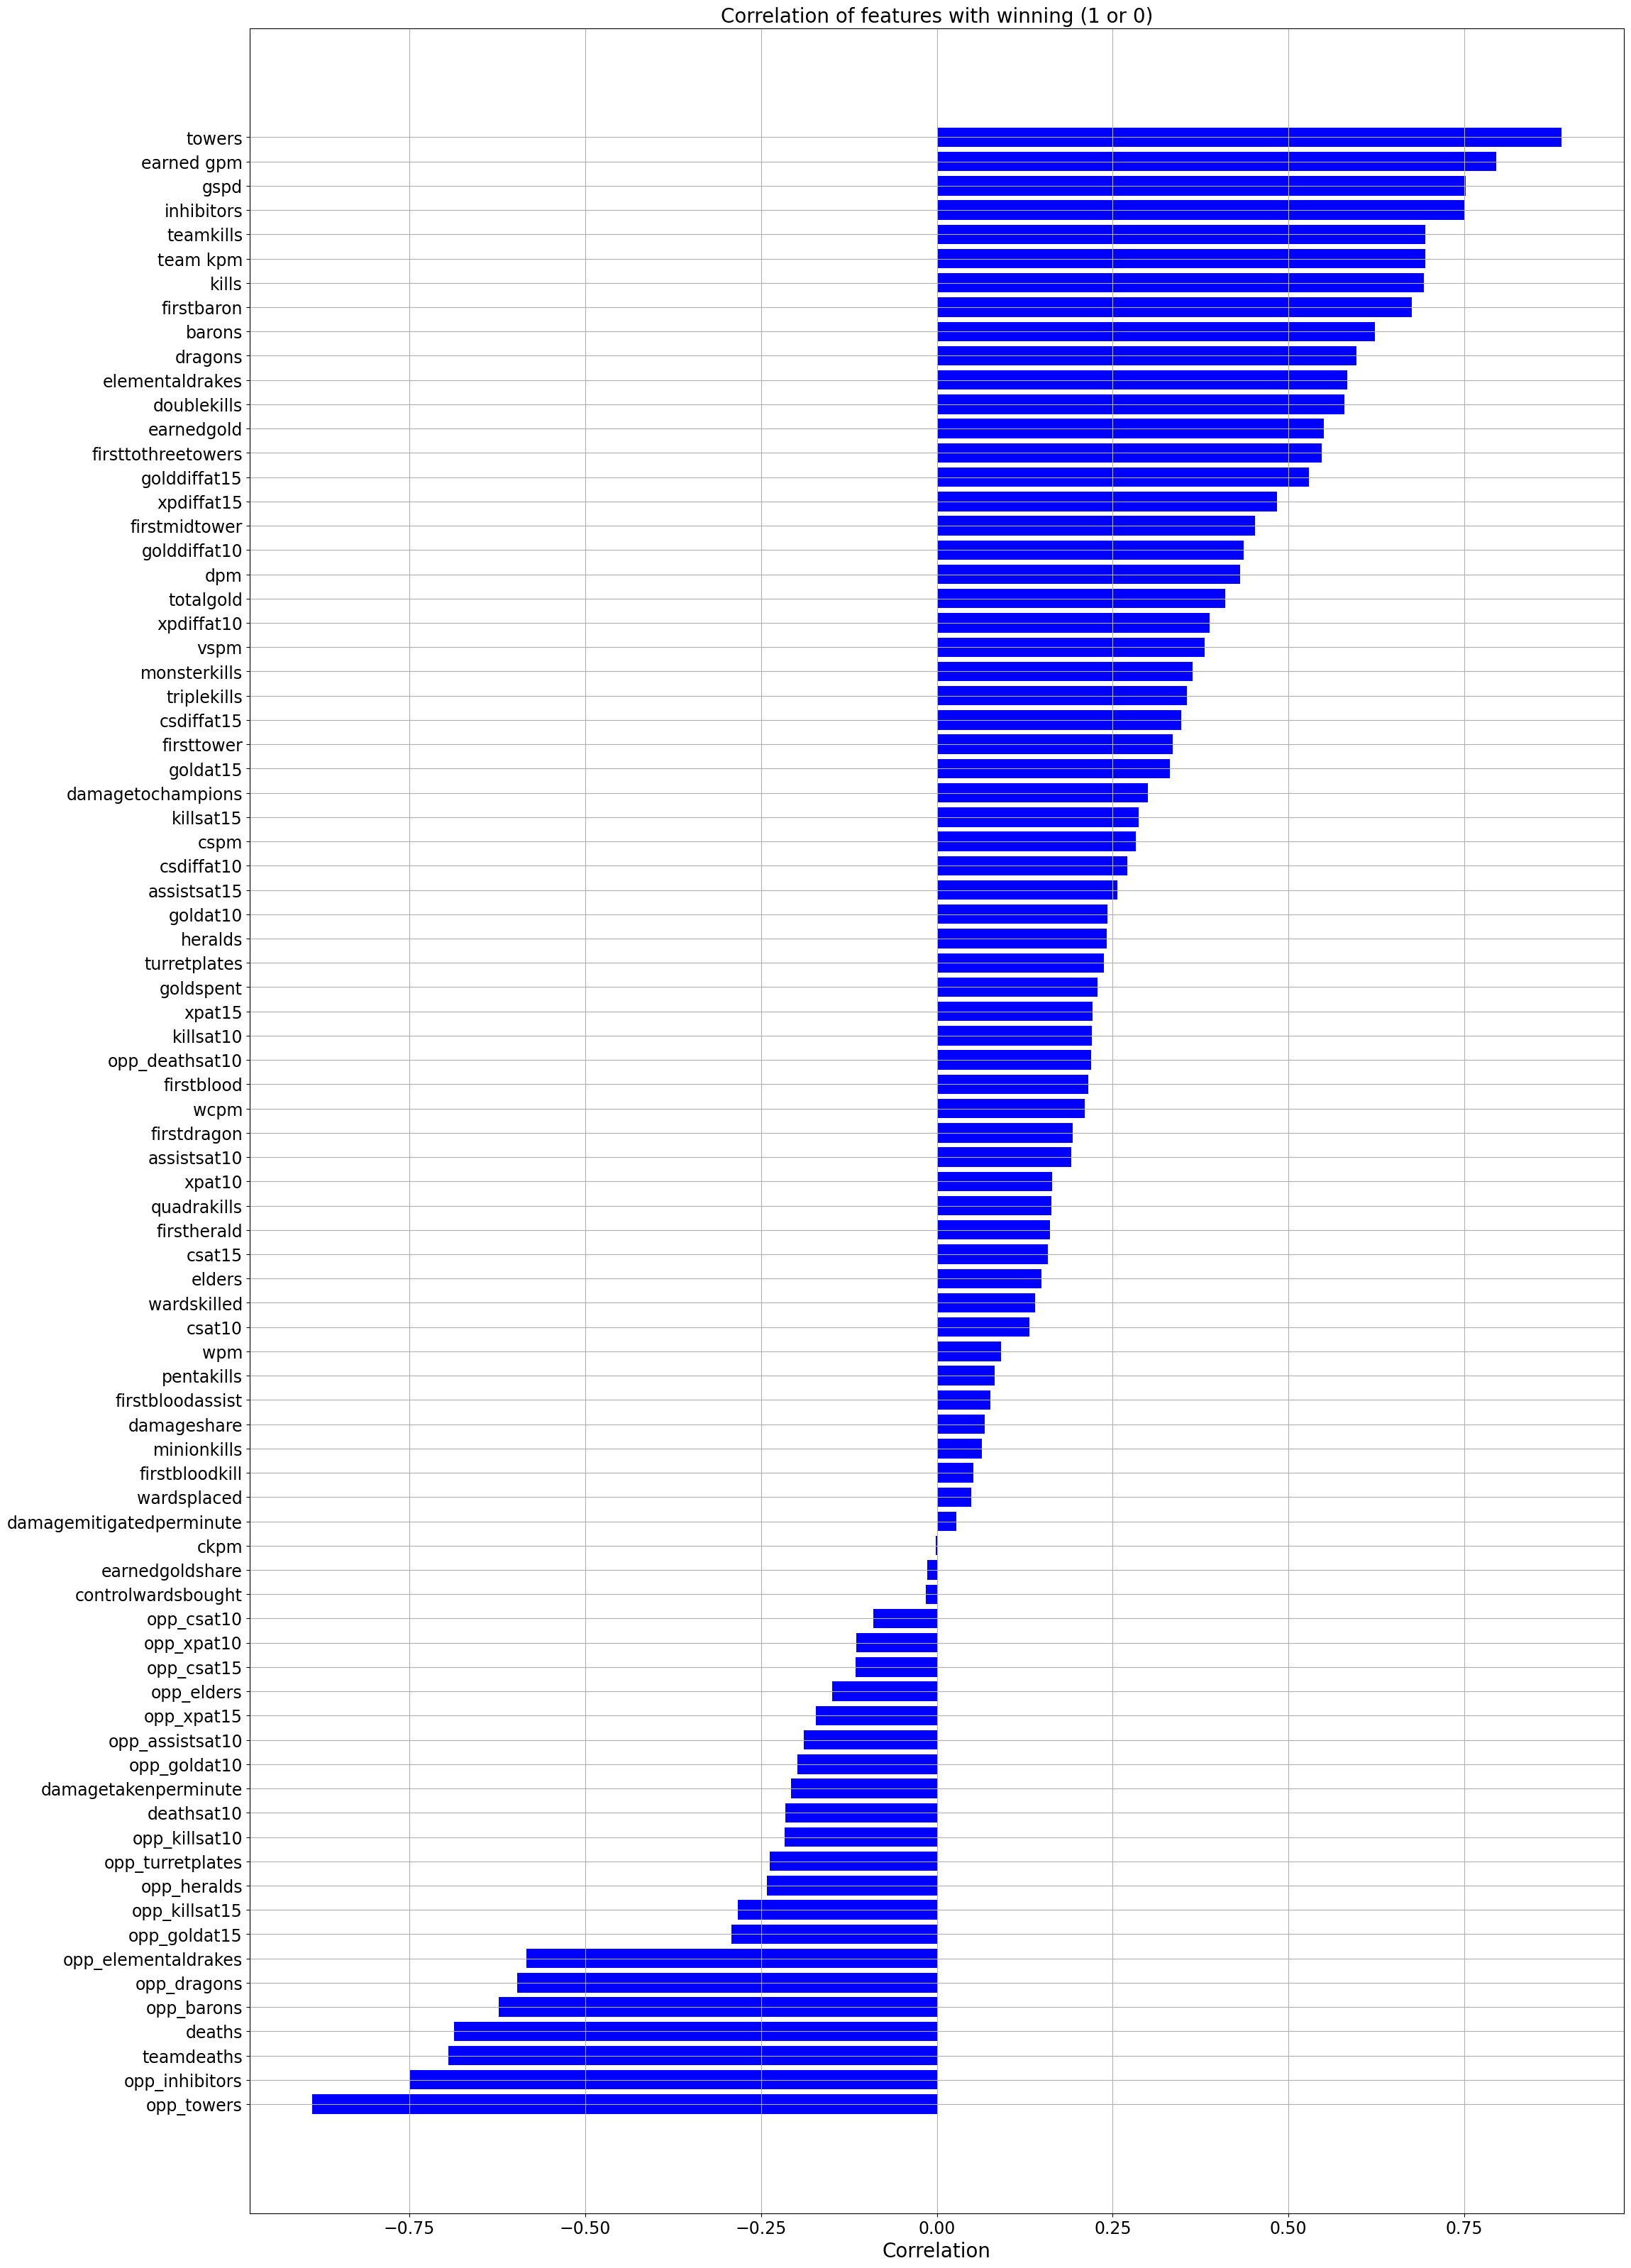

In [16]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(25, 40)
# Example data
people = correlations.index
y_pos = np.arange(len(correlations['Correlation'].values.flatten()))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))


colors = ['blue' for i in range(len(significance)) ]

ax.barh(y_pos, correlations['Correlation'].values.flatten(), align='center', color = colors)
ax.grid(True)
ax.set_yticks(y_pos, labels=people, fontsize = 19)
ax.tick_params(labelsize = 17)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Correlation of features with winning (1 or 0)", fontsize = 20)
ax.set_xlabel("Correlation", fontsize = 20)
plt.show()

**Regression**

**Dropping columns with a large number of NaNs - we need to do this so that when we do dropna, we don't lose too many rows**

In [17]:
filtered.isna().sum().sort_values().tail(15)

firstbaron              2711
pentakills              3744
quadrakills             3744
heralds                 3849
opp_heralds             3849
cspm                    4418
minionkills             4444
turretplates           11827
elementaldrakes        11827
opp_turretplates       11827
opp_elementaldrakes    11827
damageshare            13948
earnedgoldshare        13948
firstbloodassist       13951
firstbloodkill         13951
dtype: int64

In [18]:
del filtered['turretplates']
del filtered['opp_turretplates']
del filtered['elementaldrakes']
del filtered['opp_elementaldrakes']
del filtered['damageshare']
del filtered['earnedgoldshare']
del filtered['firstbloodkill']
del filtered['firstbloodassist']

**Using a classification score function to select the most relevant features**

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_classif, k=10)

	# learn relationship from training data
	fs.fit(X_train, y_train)

	cols = fs.get_support(indices=True)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs, cols
 

**Splitting into training and testing and doing feature selection**

In [20]:
together = pd.concat([filtered, filtered_y], axis = 1)
together.dropna(inplace = True) # Finally dropping the NaNs
X = together.iloc[:, :-2]
y = together.iloc[:, -1]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [22]:
feature_selection = select_features(X_train, y_train, X_test)

**Displaying the selected features**

In [23]:
X_train.iloc[:, feature_selection[3]]

,deaths,earned gpm,gspd,inhibitors,opp_inhibitors,opp_towers,team kpm,teamdeaths,teamkills,towers
53363,17,793.6527,-0.195880,0.0,2.0,9.0,0.3144,17,7,0.0
114334,2,1168.2353,0.129101,1.0,0.0,2.0,0.4629,2,16,10.0
498970,6,1175.2526,0.082629,2.0,0.0,2.0,0.3531,6,12,10.0
386038,2,1304.3596,0.088706,3.0,0.0,2.0,0.5056,2,15,11.0
67067,25,1051.2193,-0.069590,0.0,5.0,11.0,0.0903,25,3,2.0
...,...,...,...,...,...,...,...,...,...,...
493211,12,1028.9284,0.001169,0.0,1.0,7.0,0.2743,12,9,4.0
304246,4,1160.1171,0.111472,2.0,0.0,2.0,0.4685,4,16,10.0
219970,6,1306.4615,0.017617,1.0,0.0,2.0,0.5470,6,16,9.0
7583,8,1296.5591,0.077346,3.0,0.0,2.0,0.4570,8,17,9.0


**Extracting training and testing sets for the extracted features**

In [24]:
X_train_fs = feature_selection[0]
X_test_fs = feature_selection[1]


$$ \operatorname{Pr}(\text{Win} = 1)
 = \frac{\exp( \beta_{1} \text{deaths} + \beta_{2} \text{earnedgpm} + \dots +
    \beta_{10} \text{towers)} }{1 +\exp(\beta_{1} \text{deaths} + \beta_{2} \text{earnedgpm} + \dots +
    \beta_{10} \text{towers)}}$$

In [25]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(sm.add_constant(X_train_fs), y_train)

In [26]:
model.coef_

array([[-0.1265133 , -0.18913936,  0.00214834, -0.37622242,  0.03212454,
         0.39365583, -1.15436247, -0.02141059, -0.18913936,  0.37089359,
         0.79904152]])

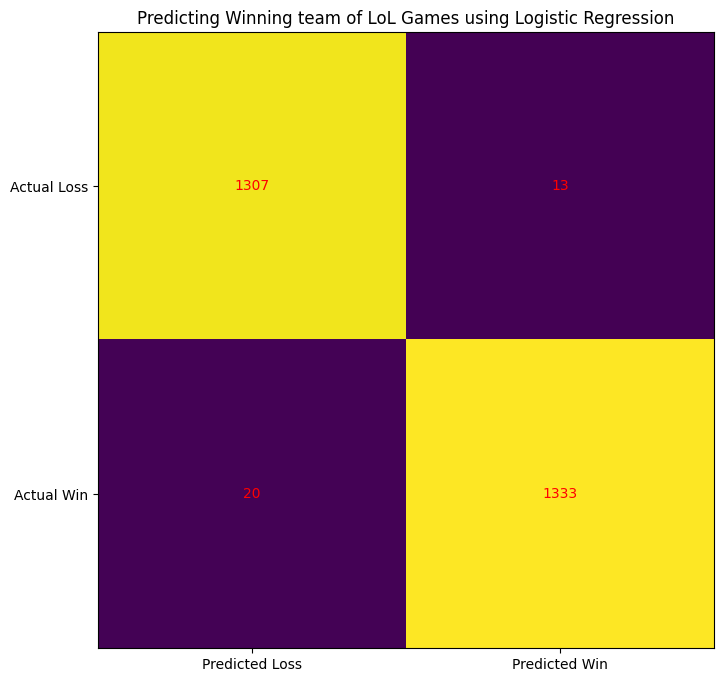

In [27]:
cm = confusion_matrix(y_test, model.predict(sm.add_constant(X_test_fs)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Loss', 'Predicted Win'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Loss', 'Actual Win'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

ax.set_title("Predicting Winning team of LoL Games using Logistic Regression")
plt.show()



In [28]:
print(classification_report(y_test, model.predict(sm.add_constant(X_test_fs))))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1320
           1       0.99      0.99      0.99      1353

    accuracy                           0.99      2673
   macro avg       0.99      0.99      0.99      2673
weighted avg       0.99      0.99      0.99      2673



In [29]:
import os

os.system('jupyter nbconvert --to html LoL_Win_Prediction.ipynb')

[NbConvertApp] Converting notebook LoL_Win_Prediction.ipynb to html
[NbConvertApp] Writing 1107809 bytes to LoL_Win_Prediction.html


0